# Proyecto Talento TECH - Pronosticos de demanda

### Contenido de cada columna:
- PAÍS: Nombre del país
- CODE_TIME: Un código que representa el mes y el año (p. ej., JAN2010 para enero de 2010)
- TIME: El mes y el año en un formato más legible para humanos (p. ej., enero de 2010)
- YEAR: El año del punto de datos
- MONTH: El mes del punto de datos como un número (1-12)
- MONTH_NAME: El mes del punto de datos como una cadena (p. ej., enero)
- PRODUCT: El tipo de producto energético (p. ej., hidroeléctrico, eólico, solar)
- VALUE: La cantidad de electricidad generada en gigavatios-hora (GWh)
- DISPLAY_ORDER: El orden en el que se deben mostrar los productos
- yearToDate: La cantidad de electricidad generada durante el año actual hasta el mes actual en GWh
- previousYearToDate: La cantidad de electricidad generada durante el año anterior hasta el mes actual en GWh
- share: La participación del producto en la generación total de electricidad para el país en formato decimal

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, learning_curve
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt



In [ ]:
# Cargar el archivo con el delimitador correcto (;)
file_path = "databproduction.csv"
df = pd.read_csv(file_path, delimiter=";")
df.head()




,COUNTRY,CODE_TIME,TIME,YEAR,MONTH,MONTH_NAME,PRODUCT,VALUE,DISPLAY_ORDER,yearToDate,previousYearToDate,share
0,Australia,JAN2010,January 2010,2010,1,January,Hydro,990.728,1,16.471.891,NaN,0.04777072935264173
1,Australia,JAN2010,January 2010,2010,1,January,Wind,409.469,2,4.940.909,NaN,0.01974369632966552
2,Australia,JAN2010,January 2010,2010,1,January,Solar,49.216,3,908.238,NaN,0.0023730874829616362
3,Australia,JAN2010,January 2010,2010,1,January,Geothermal,0.083,4,0.996,NaN,"4,00E+09"
4,Australia,JAN2010,January 2010,2010,1,January,Total combustible fuels,19289.73,7,214.302.969,NaN,0.9301084365391247


In [ ]:
df.dtypes

,0
COUNTRY,object
CODE_TIME,object
TIME,object
YEAR,int64
MONTH,int64
MONTH_NAME,object
PRODUCT,object
VALUE,object
DISPLAY_ORDER,int64
yearToDate,object


# Variable objetivo "Value"
- Conversión de variables Object a númerica
- Imputación de datos faltantes


In [ ]:
def convert_to_numeric(column):
    return column.astype(str).str.replace(".", "", regex=False).str.replace(",", ".").astype(float)
numeric_columns = ["VALUE", "yearToDate", "previousYearToDate", "share"]
for col in numeric_columns:
    df[col] = convert_to_numeric(df[col])

In [ ]:
# Eliminar valores negativos en VALUE que no sean de "Electricity trade"
df_clean = df[~((df["VALUE"] < 0) & (df["PRODUCT"] != "Electricity trade"))].copy()

# Detectar valores atípicos (percentil 99.5)
threshold = df_clean["VALUE"].quantile(0.995)

# Opcional: Filtrar valores extremadamente altos si deseas eliminarlos
df_clean = df_clean[df_clean["VALUE"] <= threshold]

# Guardar el dataset limpio
df_clean.to_csv("databproduction_clean.csv", index=False)

print("Limpieza completada. Archivo guardado como 'databproduction_clean.csv'.")

Limpieza completada. Archivo guardado como 'databproduction_clean.csv'.


In [ ]:
df_clean.dtypes


,0
COUNTRY,object
CODE_TIME,object
TIME,object
YEAR,int64
MONTH,int64
MONTH_NAME,object
PRODUCT,object
VALUE,float64
DISPLAY_ORDER,int64
yearToDate,float64


In [ ]:
df_clean.shape

(180920, 12)

In [ ]:
# Codificar la columna COUNTRY en valores numéricos
encoder = LabelEncoder()
df["COUNTRY_encoded"] = encoder.fit_transform(df["COUNTRY"])

Text(0.5, 1.0, 'Datos faltantes')

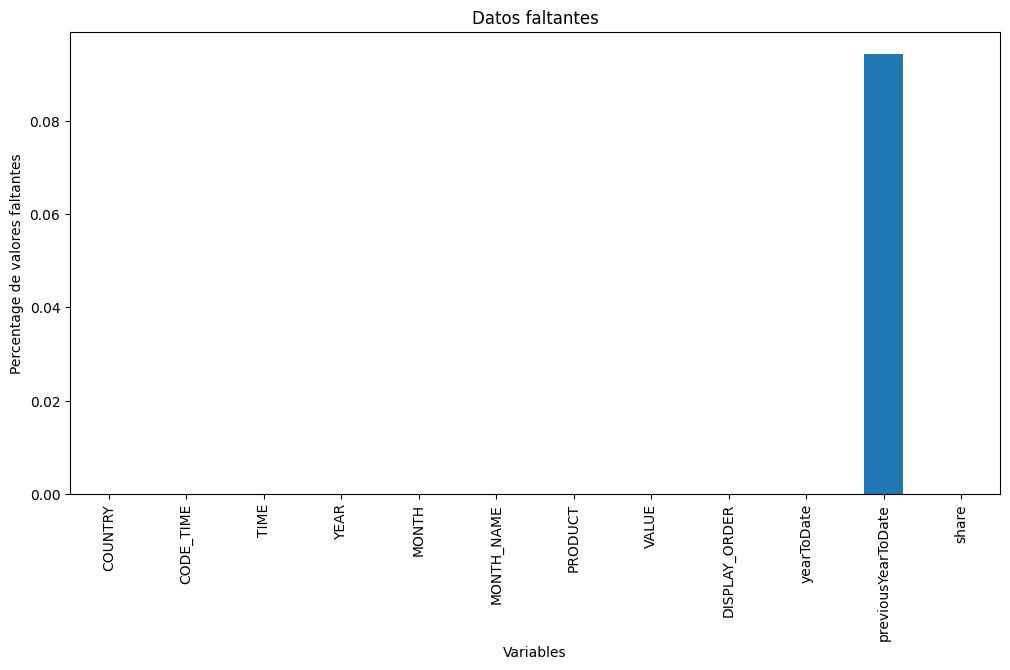

In [ ]:
df_clean.isnull().sum()

# Alternativamente podemos usar mean() con isnull() para visualizar el porcentaje de varoleres faltantes en cada variable
df_clean.isnull().mean()

# Podemos tambien graficar el porcentaje de valores faltantes con
# pandas plot.bar()

df_clean.isnull().mean().plot.bar(figsize=(12,6))
plt.ylabel('Percentage de valores faltantes')
plt.xlabel('Variables')
plt.title('Datos faltantes')

# Filtrar datos a solo Colombia, Estados Unidos y Brazil

In [ ]:
# Filtrar solo los países deseados
df_filtered = df_clean[df_clean["COUNTRY"].isin(["Colombia", "Brazil", "United States"])]
df_filtered["COUNTRY"].value_counts()


,count
COUNTRY,
United States,4104
Colombia,2548
Brazil,2328


In [ ]:
df_filtered.head()

,COUNTRY,CODE_TIME,TIME,YEAR,MONTH,MONTH_NAME,PRODUCT,VALUE,DISPLAY_ORDER,yearToDate,previousYearToDate,share
940,United States,JAN2010,January 2010,2010,1,January,Hydro,2428386.0,1,284270.0,NaN,6.666426e+15
941,United States,JAN2010,January 2010,2010,1,January,Wind,6964964.0,2,94651999.0,NaN,1.912028e+15
942,United States,JAN2010,January 2010,2010,1,January,Solar,28868.0,3,3847998.0,NaN,7.920000e+10
943,United States,JAN2010,January 2010,2010,1,January,Geothermal,1333378.0,4,15219001.0,NaN,3.660401e+16
944,United States,JAN2010,January 2010,2010,1,January,Nuclear,72569314.0,6,806968001.0,NaN,1.992179e+16


<ipython-input-15-a08f5bbe97f3>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="COUNTRY", y="VALUE", data=df_filtered, palette="Set2")


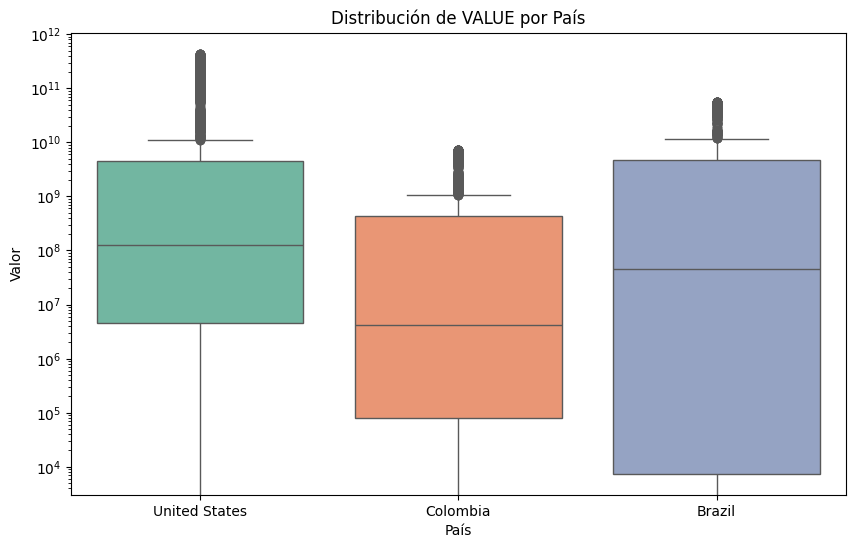

In [ ]:
# Filtrar los datos solo para Colombia, Brasil y Estados Unidos
df_filtered = df[df["COUNTRY"].isin(["Colombia", "Brazil", "United States"])]

# Crear un boxplot para visualizar la distribución de VALUE por país
plt.figure(figsize=(10, 6))
sns.boxplot(x="COUNTRY", y="VALUE", data=df_filtered, palette="Set2")

# Configuración de la gráfica
plt.title("Distribución de VALUE por País")
plt.xlabel("País")
plt.ylabel("Valor")
plt.yscale("log")  # Escala logarítmica si los valores tienen mucha variación
plt.show()

In [ ]:
num_unique_products = df["PRODUCT"].nunique()

# Obtener la lista completa de valores únicos
unique_products = df["PRODUCT"].unique()

# Mostrar resultados
print(f"Cantidad de valores únicos en 'PRODUCT': {num_unique_products}")
print("Lista de valores únicos:")
print(unique_products)

Cantidad de valores únicos en 'PRODUCT': 27
Lista de valores únicos:
['Hydro' 'Wind' 'Solar' 'Geothermal' 'Total combustible fuels' 'Coal'
 'Oil' 'Natural gas' 'Combustible renewables' 'Net electricity production'
 'Electricity supplied' 'Used for pumped storage' 'Distribution losses'
 'Final consumption' 'Renewables' 'Non-renewables' 'Others'
 'Other renewables aggregated' 'Low carbon' 'Fossil fuels'
 'Other combustible non-renewables' 'Not specified' 'Total imports'
 'Total exports' 'Electricity trade' 'Nuclear' 'Other renewables']


Grafica de "Value" por país y tipo de generación eléctrica

<ipython-input-17-59a7c3e38ac8>:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="COUNTRY", y="VALUE", hue="PRODUCT", data=df_filtered, estimator=sum, ci=None)


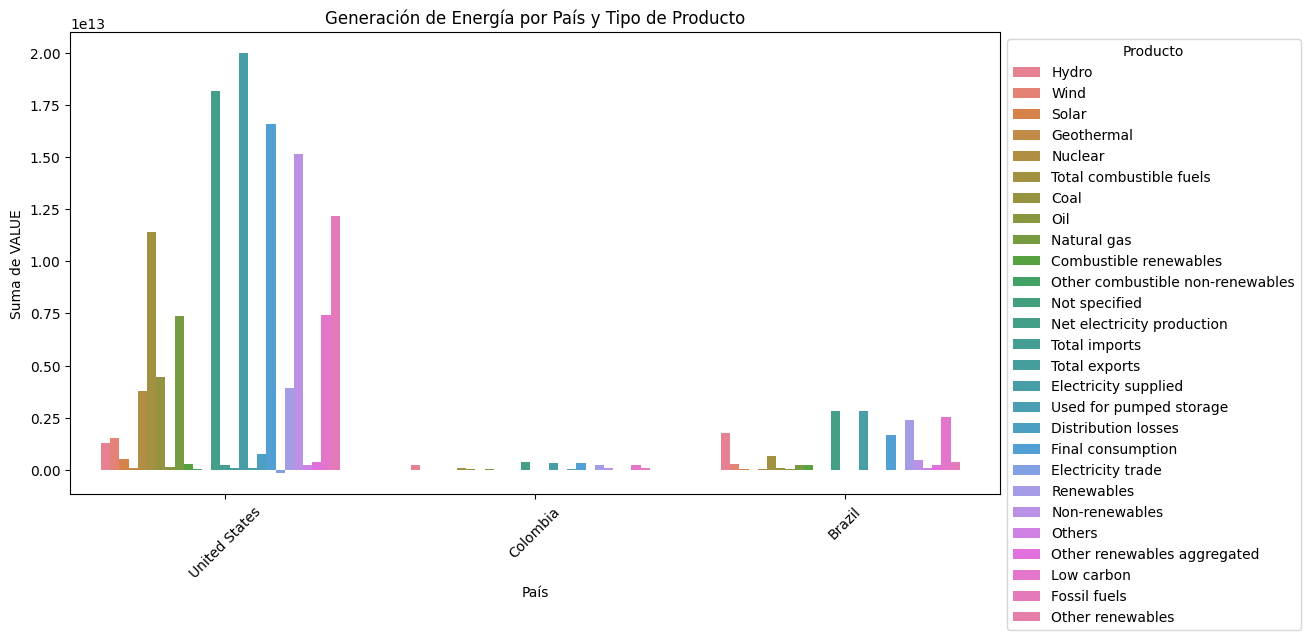

In [ ]:
# Filtrar solo los países de interés
df_filtered = df[df["COUNTRY"].isin(["Colombia", "Brazil", "United States"])]

# Crear la gráfica de barras
plt.figure(figsize=(12, 6))
sns.barplot(x="COUNTRY", y="VALUE", hue="PRODUCT", data=df_filtered, estimator=sum, ci=None)

# Configuración de la gráfica
plt.title("Generación de Energía por País y Tipo de Producto")
plt.xlabel("País")
plt.ylabel("Suma de VALUE")
plt.legend(title="Producto", bbox_to_anchor=(1, 1))  # Mueve la leyenda fuera para mejor visualización
plt.xticks(rotation=45)  # Rotar etiquetas si es necesario
plt.show()

# Transformación Logaritmica para ver mejor los datos

<ipython-input-18-4d02d7d3107e>:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="COUNTRY", y="VALUE", hue="PRODUCT", data=df_filtered, estimator=sum, ci=None)


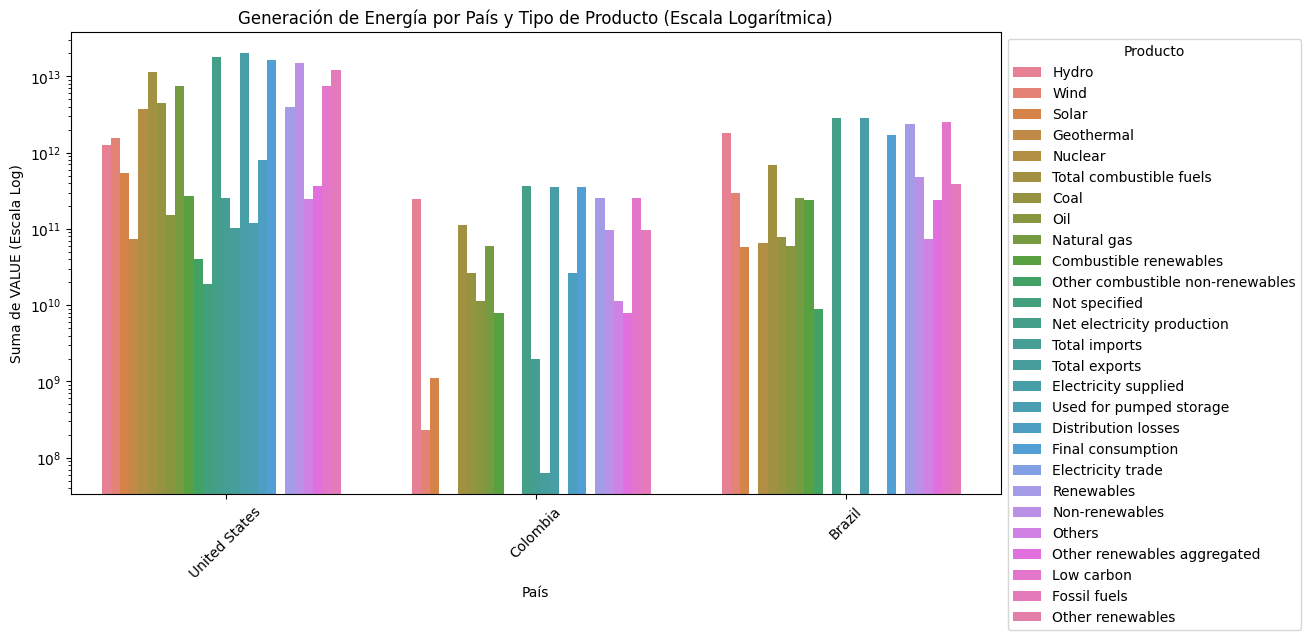

In [ ]:
# Crear la gráfica de barras con escala logarítmica
plt.figure(figsize=(12, 6))
sns.barplot(x="COUNTRY", y="VALUE", hue="PRODUCT", data=df_filtered, estimator=sum, ci=None)

# Aplicar escala logarítmica en el eje Y
plt.yscale("log")

# Configuración de la gráfica
plt.title("Generación de Energía por País y Tipo de Producto (Escala Logarítmica)")
plt.xlabel("País")
plt.ylabel("Suma de VALUE (Escala Log)")
plt.legend(title="Producto", bbox_to_anchor=(1, 1))  # Mueve la leyenda fuera para mejor visualización
plt.xticks(rotation=45)  # Rotar etiquetas si es necesario
plt.show()

Correlación con COUNTRY:
COUNTRY_encoded       1.000000
yearToDate            0.195465
VALUE                 0.189255
previousYearToDate    0.152094
share                 0.076894
DISPLAY_ORDER         0.020853
PRODUCT_encoded       0.013048
MONTH                 0.000209
YEAR                 -0.328644
Name: COUNTRY_encoded, dtype: float64

Correlación con PRODUCT:
PRODUCT_encoded       1.000000
share                 0.062244
COUNTRY_encoded       0.013048
YEAR                  0.009575
MONTH                 0.000052
previousYearToDate   -0.088487
yearToDate           -0.099730
VALUE                -0.110913
DISPLAY_ORDER        -0.132481
Name: PRODUCT_encoded, dtype: float64


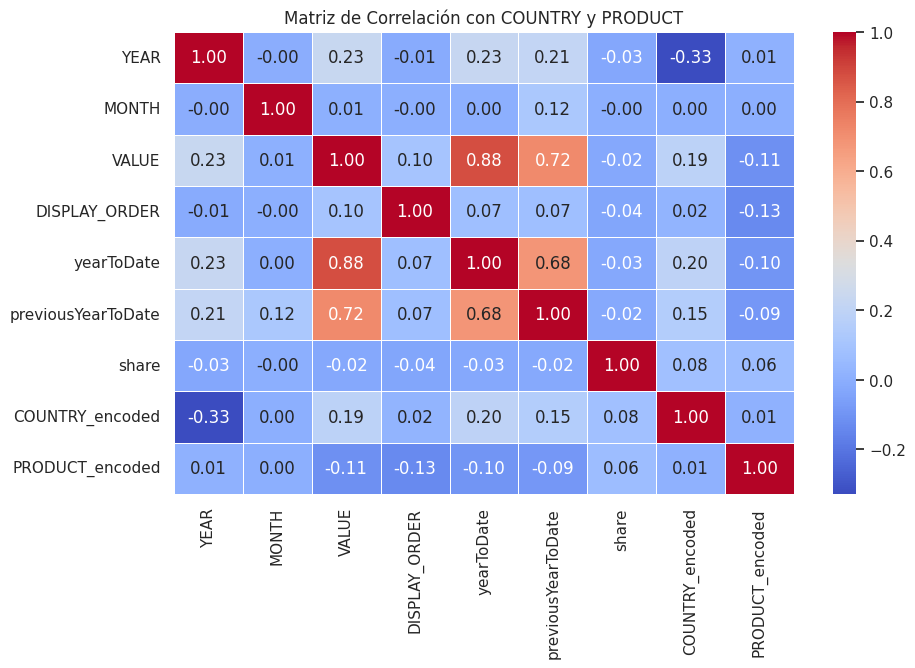

In [ ]:
# Codificar las columnas COUNTRY y PRODUCT a valores numéricos
encoder_country = LabelEncoder()
encoder_product = LabelEncoder()

# Usar .loc para asignar valores a las nuevas columnas
df_filtered.loc[:, "COUNTRY_encoded"] = encoder_country.fit_transform(df_filtered["COUNTRY"])
df_filtered.loc[:, "PRODUCT_encoded"] = encoder_product.fit_transform(df_filtered["PRODUCT"])

# Calcular la matriz de correlación
corr_matrix = df_filtered.corr(numeric_only=True)

# Extraer solo la correlación con "COUNTRY_encoded" y "PRODUCT_encoded"
corr_with_country = corr_matrix["COUNTRY_encoded"].sort_values(ascending=False)
corr_with_product = corr_matrix["PRODUCT_encoded"].sort_values(ascending=False)

# Mostrar las correlaciones más altas
print("Correlación con COUNTRY:")
print(corr_with_country)

print("\nCorrelación con PRODUCT:")
print(corr_with_product)

# Visualizar la matriz de correlación con un heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Matriz de Correlación con COUNTRY y PRODUCT")
plt.show()

plt.show()

Se elimina la columna "code_time", ya que se considera poco relevante

In [ ]:
df_filtered = df_clean[df_clean["COUNTRY"].isin(["Colombia", "Brazil", "United States"])]
df_filtered = df_filtered.loc[:, df_filtered.columns != "CODE_TIME"]  # Usando .loc para eliminar columna


In [ ]:
df_filtered.head()

,COUNTRY,TIME,YEAR,MONTH,MONTH_NAME,PRODUCT,VALUE,DISPLAY_ORDER,yearToDate,previousYearToDate,share
940,United States,January 2010,2010,1,January,Hydro,2428386.0,1,284270.0,NaN,6.666426e+15
941,United States,January 2010,2010,1,January,Wind,6964964.0,2,94651999.0,NaN,1.912028e+15
942,United States,January 2010,2010,1,January,Solar,28868.0,3,3847998.0,NaN,7.920000e+10
943,United States,January 2010,2010,1,January,Geothermal,1333378.0,4,15219001.0,NaN,3.660401e+16
944,United States,January 2010,2010,1,January,Nuclear,72569314.0,6,806968001.0,NaN,1.992179e+16


In [ ]:
# Definir función para detectar outliers usando el rango intercuartil (IQR)
def detectar_outliers(df, columna):
    Q1 = df[columna].quantile(0.25)  # Primer cuartil
    Q3 = df[columna].quantile(0.75)  # Tercer cuartil
    IQR = Q3 - Q1  # Rango intercuartil
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR
    outliers = df[(df[columna] < limite_inferior) | (df[columna] > limite_superior)]
    return outliers

# Detectar outliers en VALUE por país y producto dentro de df_filtered
for pais in df_filtered["COUNTRY"].unique():
    for producto in df_filtered["PRODUCT"].unique():
        df_filtrado = df_filtered[(df_filtered["COUNTRY"] == pais) & (df_filtered["PRODUCT"] == producto)]
        outliers = detectar_outliers(df_filtrado, "VALUE")

        if not outliers.empty:
            print(f"Outliers en {pais} - {producto}:")
            print(outliers[["COUNTRY", "PRODUCT", "VALUE"]], "\n")


Outliers en United States - Solar:
              COUNTRY PRODUCT         VALUE
172668  United States   Solar  1.754040e+10
173823  United States   Solar  1.970431e+10
174978  United States   Solar  2.070308e+10
176133  United States   Solar  2.037332e+10
177287  United States   Solar  1.859066e+10
178442  United States   Solar  1.743742e+10 

Outliers en United States - Oil:
              COUNTRY PRODUCT         VALUE
103066  United States     Oil  8.605433e+09
181896  United States     Oil  7.130296e+09 

Outliers en United States - Not specified:
              COUNTRY        PRODUCT         VALUE
162435  United States  Not specified  1.204946e+09 

Outliers en United States - Total exports:
              COUNTRY        PRODUCT         VALUE
119597  United States  Total exports  3.465578e+09
120974  United States  Total exports  3.936460e+09
122351  United States  Total exports  4.830144e+09
123728  United States  Total exports  4.776011e+09
125105  United States  Total exports  4.070

In [ ]:
# Ver cuántos valores nulos tiene cada columna
print(df_filtered.isnull().sum())

# En lugar de:
# df_filtered.fillna(df_filtered.median(numeric_only=True), inplace=True)
df_filtered = df_filtered.fillna(df_filtered.median(numeric_only=True))

# Y en lugar de:
# for col in df_filtered.select_dtypes(include=['object']):
#    df_filtered[col].fillna(df_filtered[col].mode()[0], inplace=True)
for col in df_filtered.select_dtypes(include=['object']):
    df_filtered.loc[:, col] = df_filtered[col].fillna(df_filtered[col].mode()[0])


COUNTRY                 0
TIME                    0
YEAR                    0
MONTH                   0
MONTH_NAME              0
PRODUCT                 0
VALUE                   0
DISPLAY_ORDER           0
yearToDate              0
previousYearToDate    963
share                   0
dtype: int64


### analisis de la distribución de Value por Pais para saber si hay cesgos

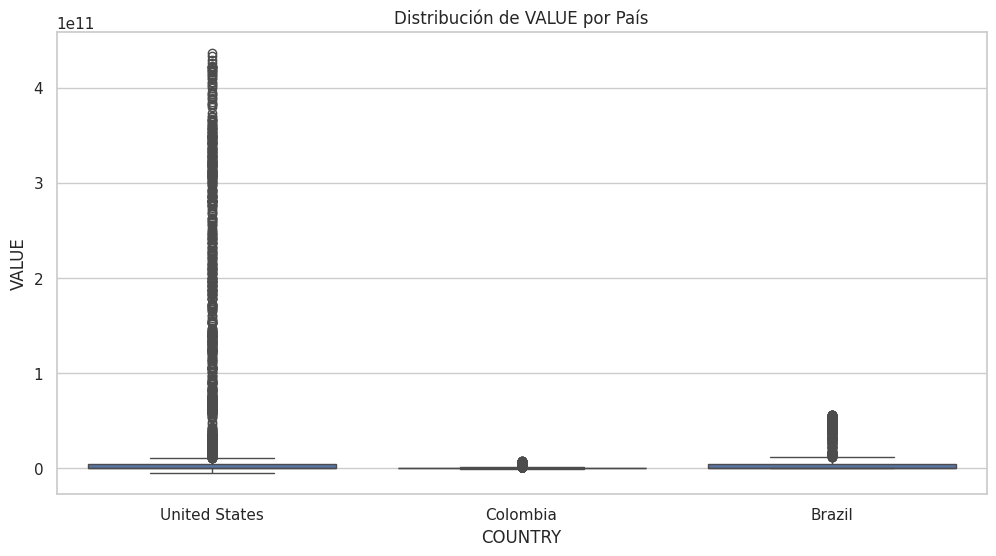

In [ ]:


plt.figure(figsize=(12, 6))
sns.boxplot(x="COUNTRY", y="VALUE", data=df_filtered)
plt.title("Distribución de VALUE por País")
plt.show()


In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Crea un objeto MinMaxScaler
scaler = MinMaxScaler()

# Escala VALUE dentro de cada grupo de país
df_filtered['VALUE_scaled'] = df_filtered.groupby('COUNTRY')['VALUE'].transform(lambda x: scaler.fit_transform(x.values.reshape(-1, 1)).ravel())

# Ahora 'VALUE_scaled' contiene los valores escalados dentro de cada país

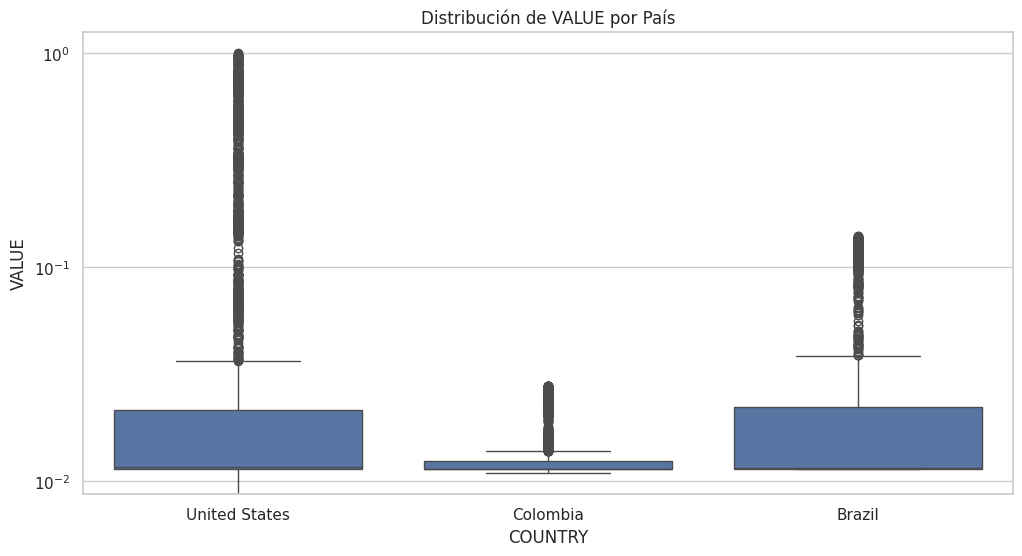

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(x="COUNTRY", y="VALUE", data=df_filtered)
plt.title("Distribución de VALUE por País")
plt.yscale("log")
plt.show()

#  Se va a probar el modelo con random Forest

- Esta es la primera fase de pruebas con Random Forest.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

df_filtered['year_sin'] = np.sin(2 * np.pi * df_filtered['YEAR'] / df_filtered['YEAR'].max())
df_filtered['year_cos'] = np.cos(2 * np.pi * df_filtered['YEAR'] / df_filtered['YEAR'].max())

# Codificar las columnas COUNTRY y PRODUCT a valores numéricos
encoder_country = LabelEncoder()
encoder_product = LabelEncoder()

# Usar .loc para asignar valores a las nuevas columnas DIRECTAMENTE EN df_filtered
df_filtered.loc[:, "COUNTRY_encoded"] = encoder_country.fit_transform(df_filtered["COUNTRY"])
df_filtered.loc[:, "PRODUCT_encoded"] = encoder_product.fit_transform(df_filtered["PRODUCT"])

# ... (resto del código)

# Definir variables predictoras y variable objetivo
X = df_filtered[['COUNTRY_encoded', 'PRODUCT_encoded', 'YEAR', 'MONTH']]
y = df_filtered['VALUE']

# Dividir datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Definir y entrenar el modelo
rf_model = RandomForestRegressor(
    n_estimators=150,
    max_features=0.8,
    max_samples=0.9,
    min_samples_split=5,
    bootstrap=True,
    random_state=42
)

rf_model.fit(X_train, y_train)

# Hacer predicciones
y_pred = rf_model.predict(X_test)

# Evaluación del modelo
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Imprimir métricas
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"R²: {r2}")


MAE: 0.00997830286758437
MSE: 0.002017638656183248
R²: 0.8869035917903464


### Modelo predictor


In [ ]:


# Crear un DataFrame vacío para almacenar predicciones
future_predictions = []

# Definir los próximos 12 meses para la predicción
future_years = [max(df_filtered['YEAR']) + 1]  # Año siguiente
future_months = list(range(1, 13))  # Meses de 1 a 12

# Hacer predicciones por cada país y producto
for country in df_filtered['COUNTRY_encoded'].unique():
    for product in df_filtered['PRODUCT_encoded'].unique():
        for year in future_years:
            for month in future_months:
                # Crear la entrada para el modelo
                input_data = pd.DataFrame([[country, product, year, month]],
                         columns=['COUNTRY_encoded', 'PRODUCT_encoded', 'YEAR', 'MONTH'])


                # Hacer la predicción
                predicted_value = rf_model.predict(input_data)[0]

                # Guardar la predicción
                future_predictions.append({
                    'COUNTRY_encoded': country,
                    'PRODUCT_encoded': product,
                    'YEAR': year,
                    'MONTH': month,
                    'PREDICTED_VALUE': predicted_value
                })

# Convertir la lista en un DataFrame
df_predictions = pd.DataFrame(future_predictions)

# Mostrar las primeras filas de las predicciones
print(df_predictions.head())


   COUNTRY_encoded  PRODUCT_encoded  YEAR  MONTH  PREDICTED_VALUE
0                2                8  2023      1         0.069021
1                2                8  2023      2         0.057739
2                2                8  2023      3         0.056861
3                2                8  2023      4         0.064711
4                2                8  2023      5         0.071022


### Graficar para ver que variables tomó el modelo.

In [ ]:
print(df_predictions.columns)


Index(['COUNTRY_encoded', 'PRODUCT_encoded', 'YEAR', 'MONTH',
       'PREDICTED_VALUE'],
      dtype='object')


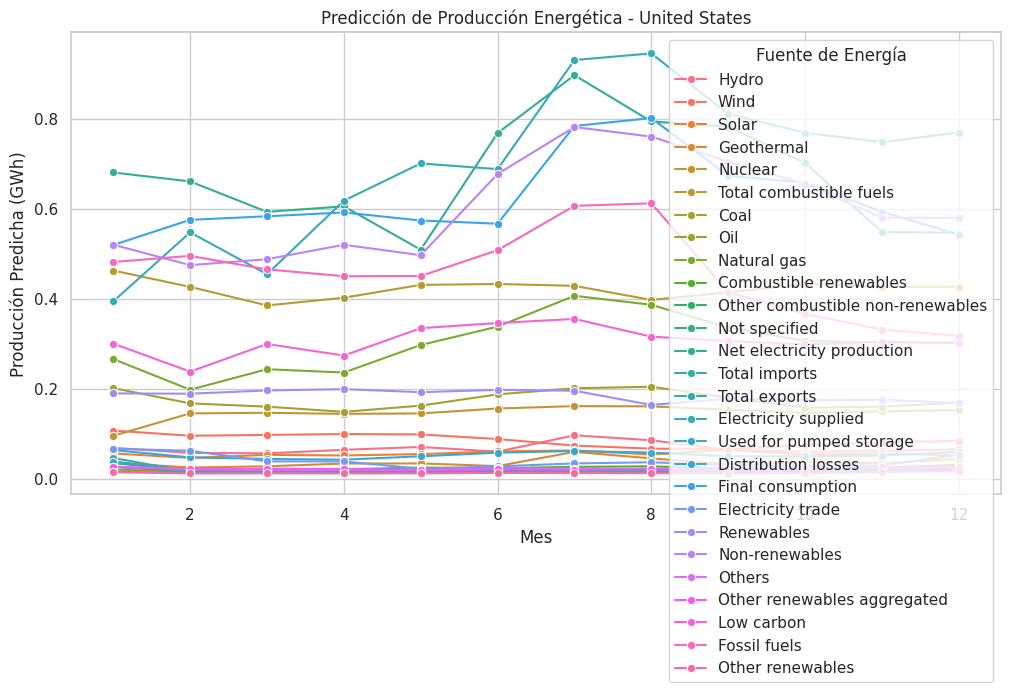

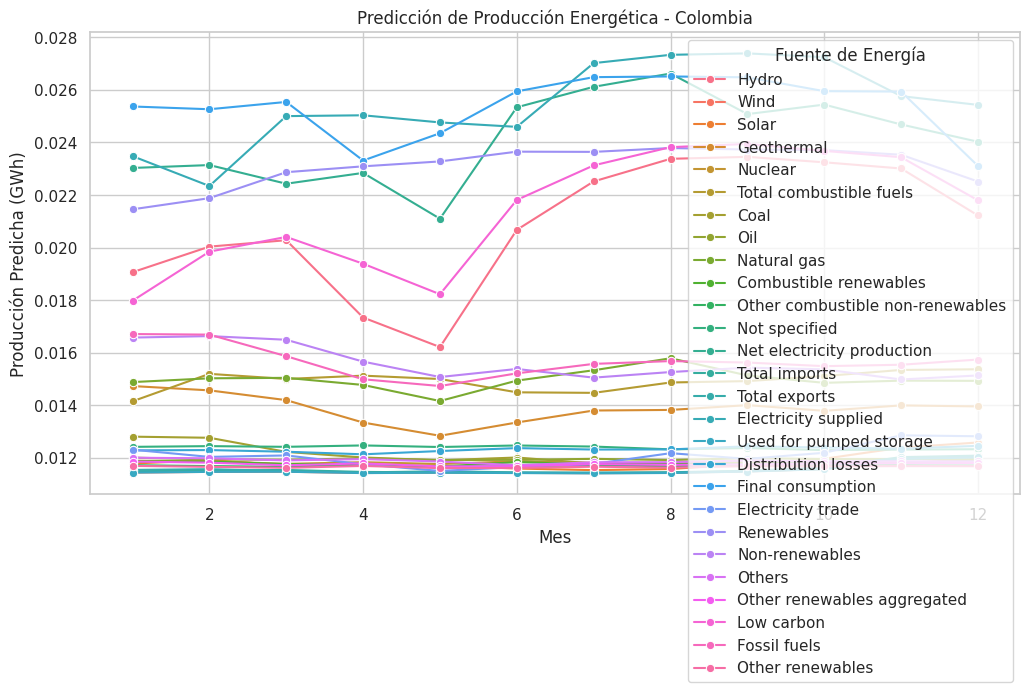

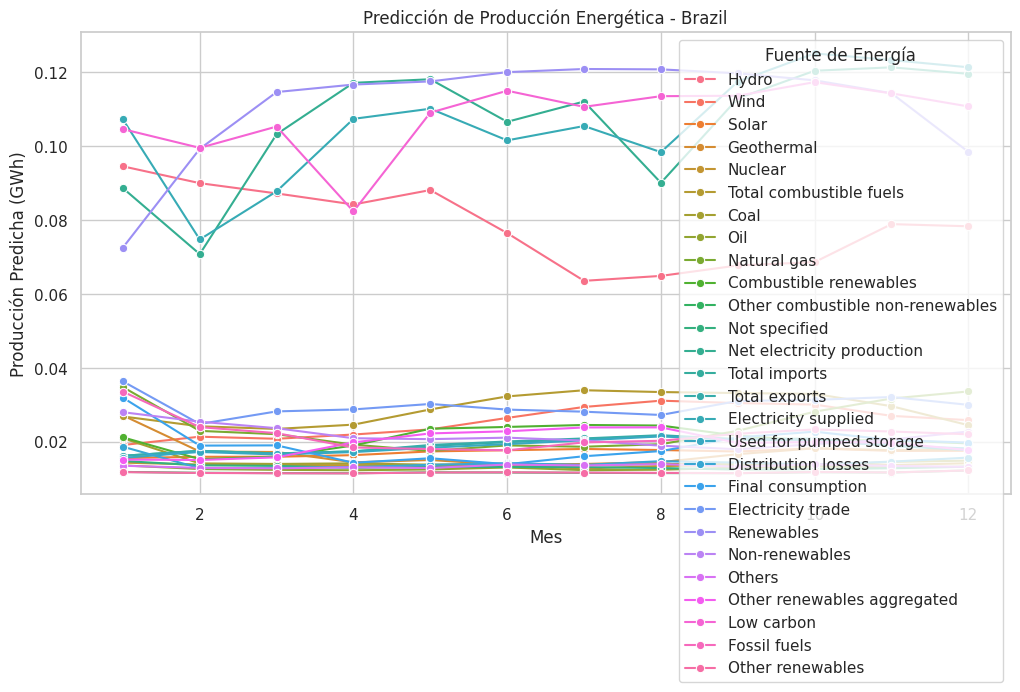

In [ ]:
# Obtener los nombres reales de los países y productos a partir de los valores codificados
paises_codificados = df_predictions["COUNTRY_encoded"].unique()
paises_nombres = encoder_country.inverse_transform(paises_codificados)

productos_codificados = df_predictions["PRODUCT_encoded"].unique()
productos_nombres = encoder_product.inverse_transform(productos_codificados)

# Crear diccionarios de mapeo entre código y nombre real
mapa_paises = dict(zip(paises_codificados, paises_nombres))
mapa_productos = dict(zip(productos_codificados, productos_nombres))

# Reemplazar los valores codificados con los nombres reales en la columna PRODUCT_encoded
df_predictions["PRODUCT"] = df_predictions["PRODUCT_encoded"].map(mapa_productos)

# Generar gráficos separados por país
for country in paises_codificados:
    plt.figure(figsize=(12, 6))

    country_data = df_predictions[df_predictions["COUNTRY_encoded"] == country]

    sns.lineplot(data=country_data, x="MONTH", y="PREDICTED_VALUE", hue="PRODUCT", marker="o")

    plt.title(f"Predicción de Producción Energética - {mapa_paises[country]}")
    plt.xlabel("Mes")
    plt.ylabel("Producción Predicha (GWh)")
    plt.legend(title="Fuente de Energía")
    plt.grid(True)

    plt.show()


optimizar el modelo con Gradient Boosting Regressor:

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit

df_filtered['year_sin'] = np.sin(2 * np.pi * df_filtered['YEAR'] / df_filtered['YEAR'].max())
df_filtered['year_cos'] = np.cos(2 * np.pi * df_filtered['YEAR'] / df_filtered['YEAR'].max())

df_filtered['year_diff'] = df_filtered['YEAR'] - 2010

# Luego incluye 'year_diff' en tus variables predictoras (X)
X = df_filtered[['COUNTRY_encoded', 'PRODUCT_encoded', 'year_diff', 'MONTH']]

# Definir variables predictoras (X) y variable objetivo (y)
#X = df_filtered[['COUNTRY_encoded', 'PRODUCT_encoded', 'YEAR', 'MONTH']]
y = df_filtered['VALUE']

# Dividir en conjunto de entrenamiento y prueba (80% - 20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Definir el modelo de Gradient Boosting
gb_model = GradientBoostingRegressor()

# Definir hiperparámetros para GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],  # Número de árboles
    'learning_rate': [0.01, 0.05, 0.1],  # Tasa de aprendizaje
    'max_depth': [3, 5, 7],  # Profundidad máxima de los árboles
    'subsample': [0.8, 1.0]  # Fracción de datos utilizada en cada iteración
}

tscv = TimeSeriesSplit(n_splits=5) #  ajustar el número de splits


# Búsqueda de hiperparámetros con GridSearchCV
grid_search = GridSearchCV(gb_model, param_grid, cv=tscv, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Mejor modelo encontrado
best_gb_model = grid_search.best_estimator_

# Hacer predicciones con el modelo optimizado
y_pred = best_gb_model.predict(X_test)

# Evaluación del modelo
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Imprimir métricas
print(f"Mejores Hiperparámetros: {grid_search.best_params_}")
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"R²: {r2}")


Mejores Hiperparámetros: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 1.0}
MAE: 0.01449363836992005
MSE: 0.0017299150863922393
R²: 0.9030316047033123


# Predicción del modelo de los siguientes 4 años por país y por producto generador de energia.

Archivo CSV generado: predicciones_energia.csv


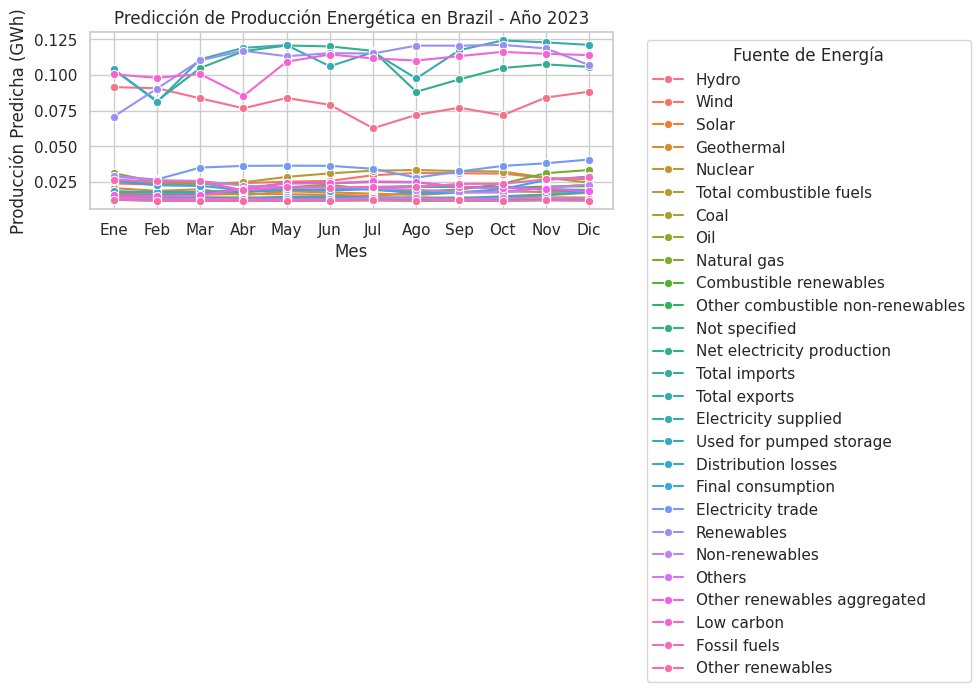

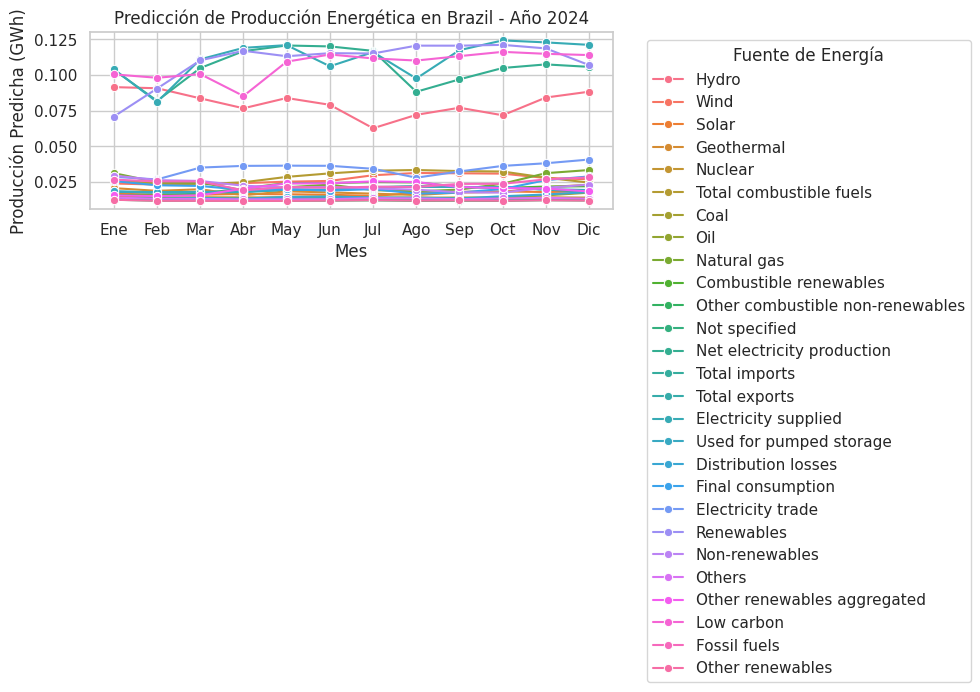

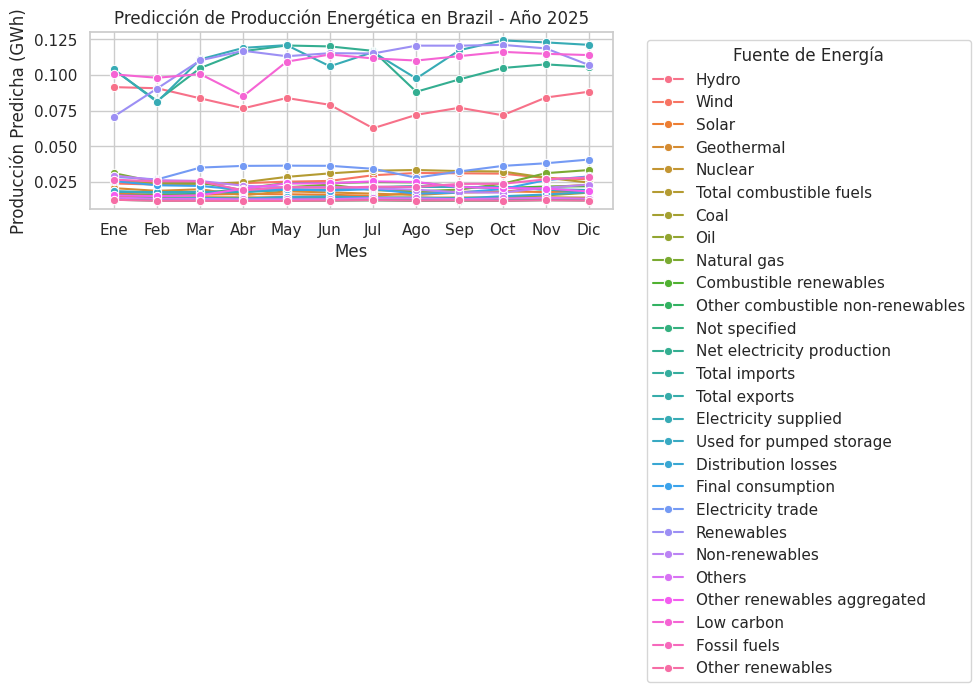

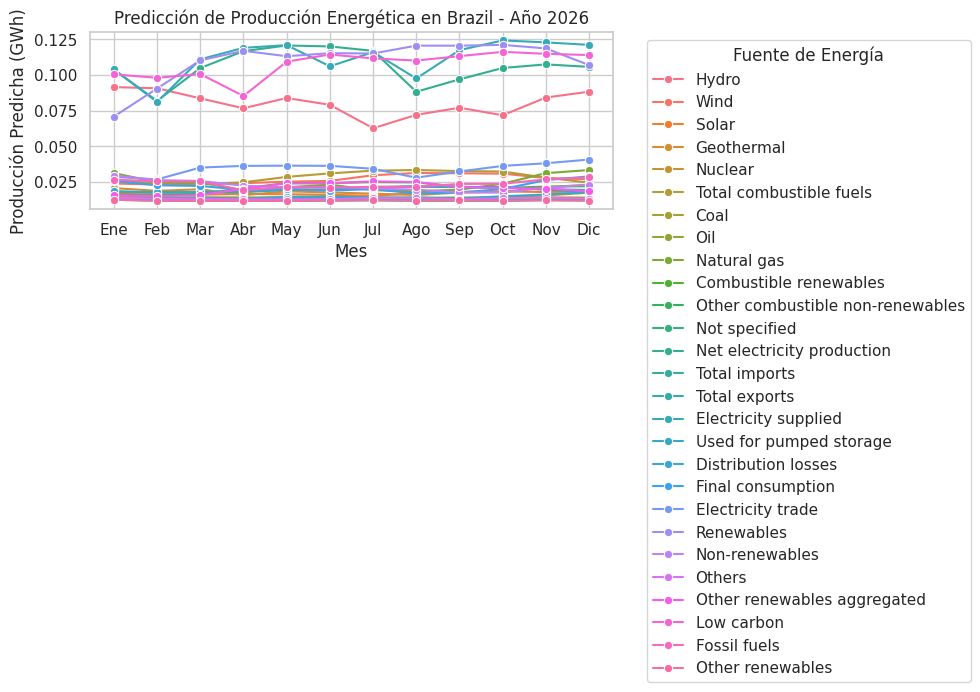

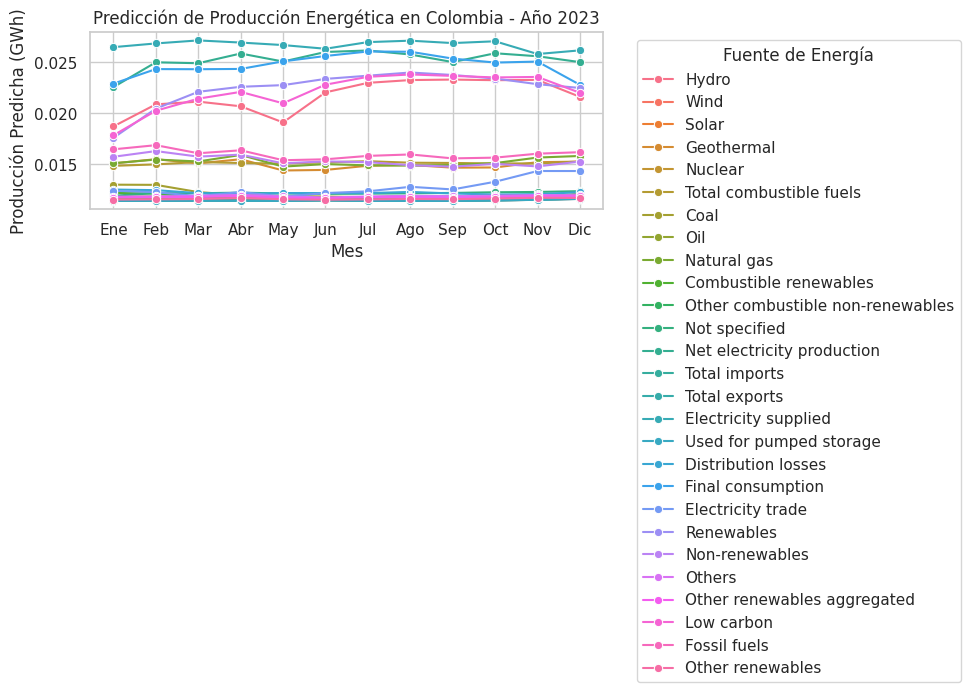

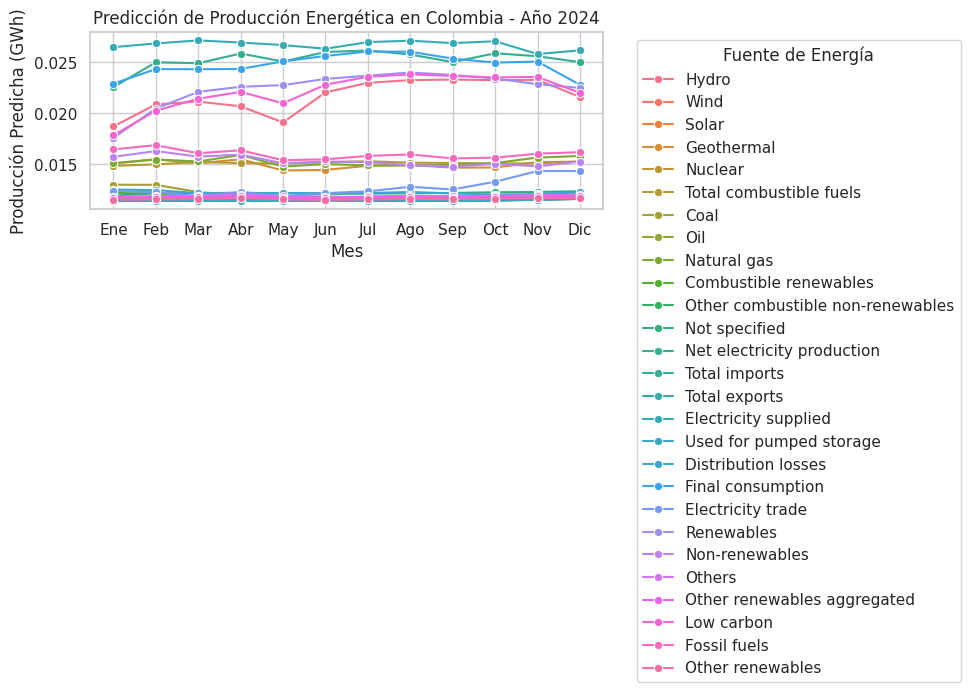

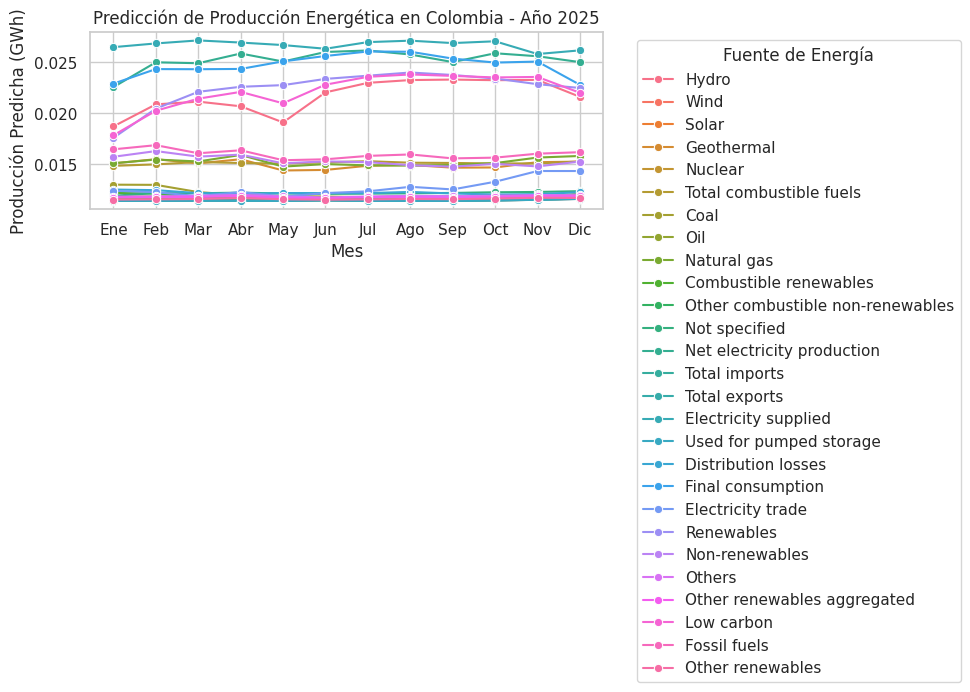

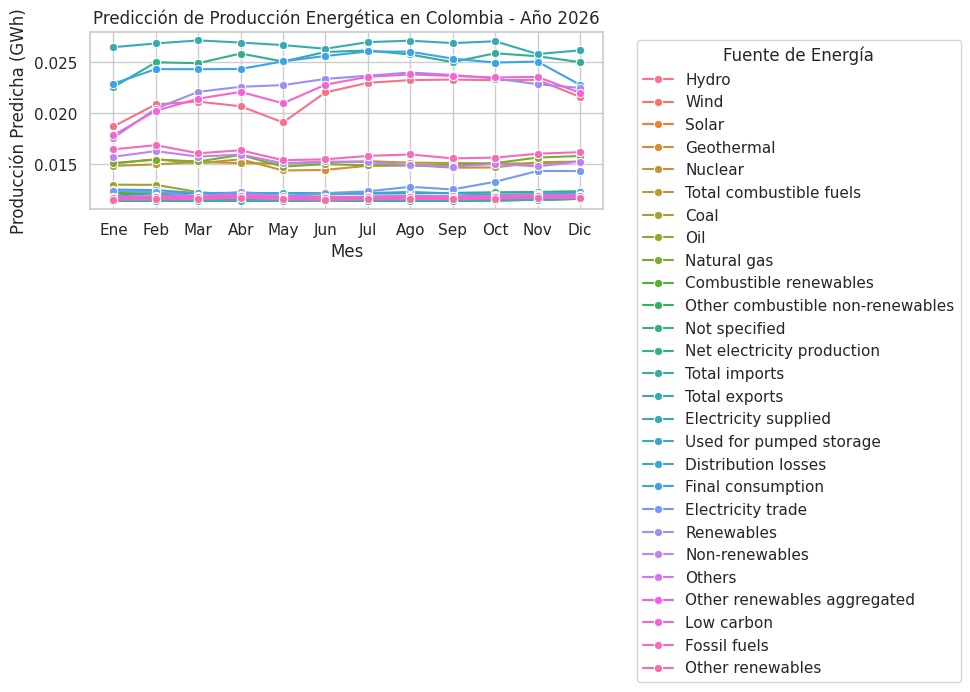

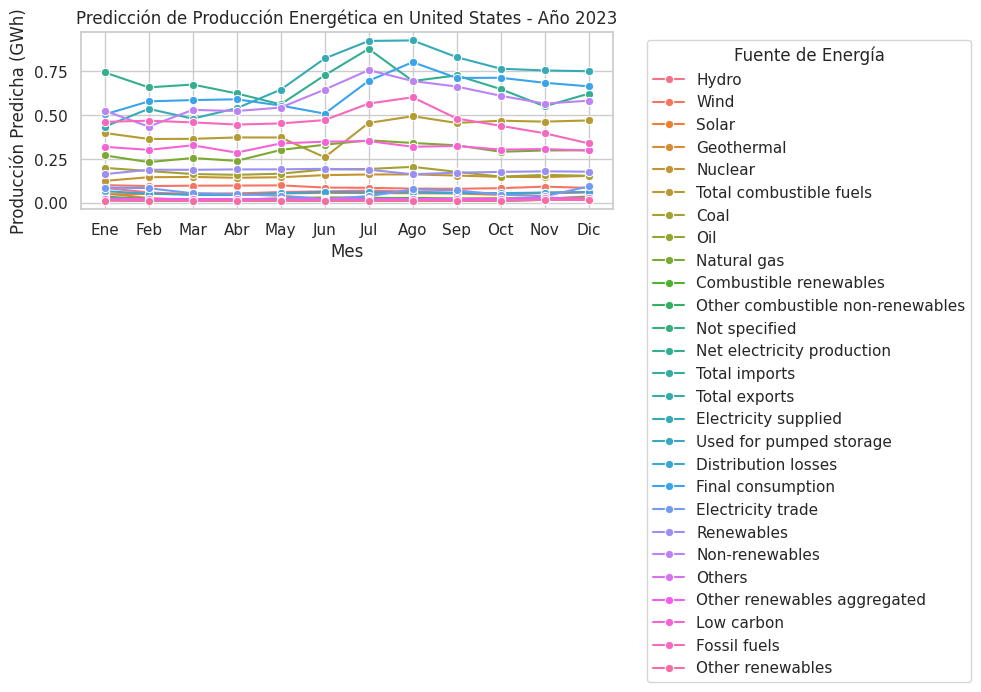

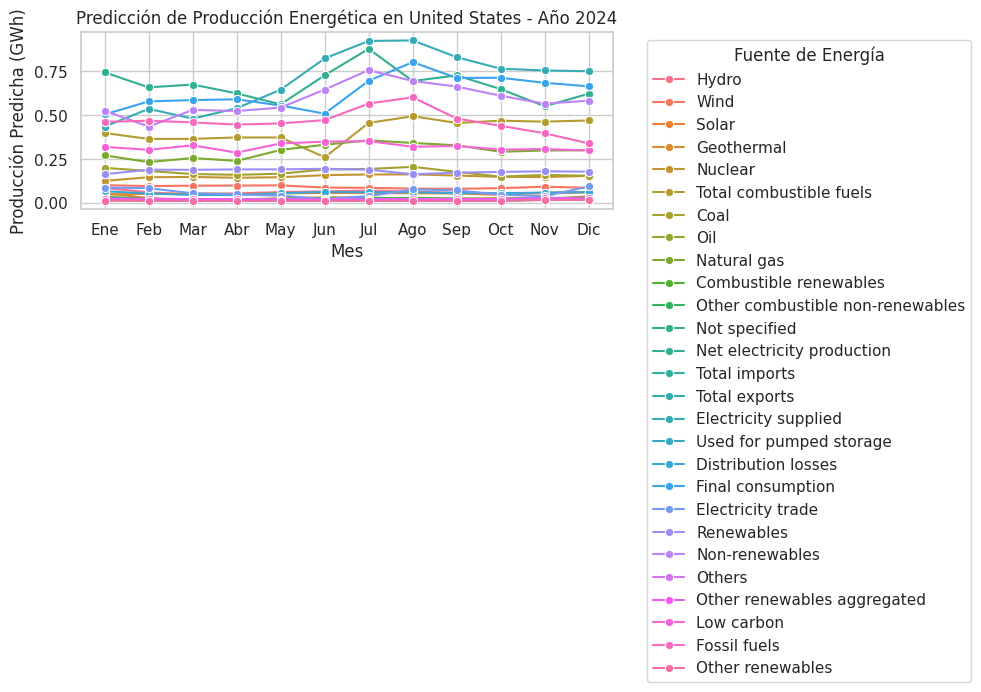

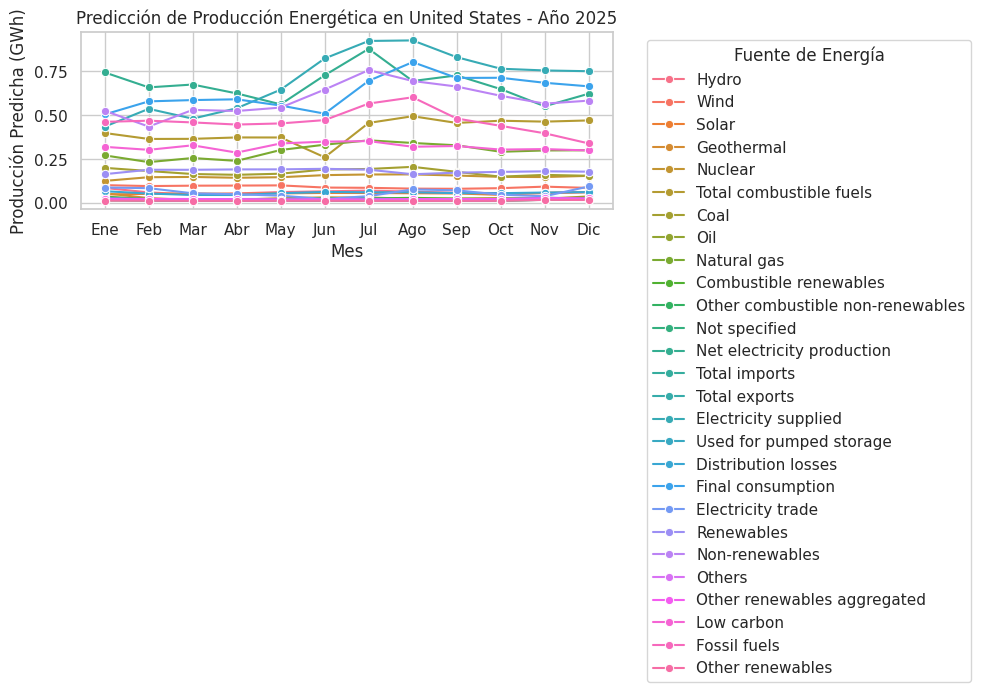

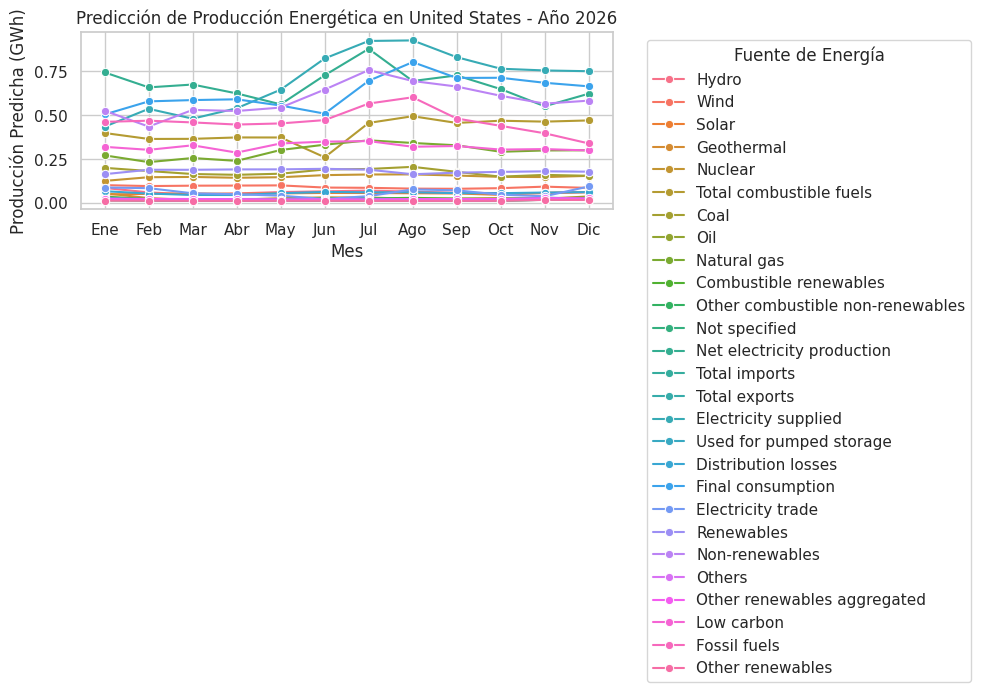

In [ ]:


# Crear una lista para almacenar predicciones ordenadas
future_predictions = []

# Definir los próximos 4 años para la predicción
future_years = list(range(max(df_filtered['YEAR']) + 1, max(df_filtered['YEAR']) + 5))  # 4 años siguientes
future_months = list(range(1, 13))  # Meses de 1 a 12

# Hacer predicciones por cada país y producto
for country in df_filtered['COUNTRY_encoded'].unique():
    for product in df_filtered['PRODUCT_encoded'].unique():
        for year in future_years:
            for month in future_months:
                # Crear la entrada para el modelo
                input_data = pd.DataFrame([[country, product, year, month]],
                         columns=['COUNTRY_encoded', 'PRODUCT_encoded', 'YEAR', 'MONTH'])


                # Hacer la predicción
                predicted_value = rf_model.predict(input_data)[0]

                # Guardar la predicción ordenadamente
                future_predictions.append({
                    'COUNTRY_encoded': country,
                    'PRODUCT_encoded': product,
                    'YEAR': year,
                    'MONTH': month,
                    'PREDICTED_VALUE': predicted_value
                })

# Convertir la lista en un DataFrame y ordenarlo
df_predictions = pd.DataFrame(future_predictions)
df_predictions = df_predictions.sort_values(by=['COUNTRY_encoded', 'YEAR', 'MONTH']).reset_index(drop=True)

# Obtener los nombres reales de los países y productos
df_predictions["COUNTRY"] = df_predictions["COUNTRY_encoded"].map(dict(zip(df_filtered["COUNTRY_encoded"], df_filtered["COUNTRY"])))
df_predictions["PRODUCT"] = df_predictions["PRODUCT_encoded"].map(dict(zip(df_filtered["PRODUCT_encoded"], df_filtered["PRODUCT"])))

# Guardar las predicciones en un archivo CSV
df_predictions.to_csv("predicciones_energia.csv", index=False)

print("Archivo CSV generado: predicciones_energia.csv")

# ----------------- MEJORA DE LAS GRÁFICAS -----------------

# Configuración global de estilo
sns.set_theme(style="whitegrid")

# Generar gráficos separados por país y año
for country in df_predictions["COUNTRY"].unique():
    country_data = df_predictions[df_predictions["COUNTRY"] == country]

    for year in future_years:
        year_data = country_data[country_data["YEAR"] == year]

        if not year_data.empty:
            plt.figure(figsize=(10, 5))  # Ajusta el tamaño de la gráfica

            # Graficar la línea
            sns.lineplot(data=year_data, x="MONTH", y="PREDICTED_VALUE", hue="PRODUCT", marker="o")

            # Personalizar el gráfico
            plt.title(f"Predicción de Producción Energética en {country} - Año {year}")
            plt.xlabel("Mes")
            plt.ylabel("Producción Predicha (GWh)")

            # Mejorar la posición de la leyenda
            plt.legend(title="Fuente de Energía", bbox_to_anchor=(1.05, 1), loc="upper left")

            # Evitar que la leyenda tape la gráfica
            plt.tight_layout()

            # Ajustar etiquetas del eje X
            plt.xticks(ticks=range(1, 13), labels=[
                "Ene", "Feb", "Mar", "Abr", "May", "Jun", "Jul", "Ago", "Sep", "Oct", "Nov", "Dic"
            ])

            # Mostrar la gráfica
            plt.show()


Ver data set de prediccines

In [ ]:
file_path = "predicciones_energia.csv"
df_predictions = pd.read_csv(file_path, delimiter=",")
df_predictions.head(20)

,COUNTRY_encoded,PRODUCT_encoded,YEAR,MONTH,PREDICTED_VALUE,COUNTRY,PRODUCT
0,0,8,2023,1,0.091495,Brazil,Hydro
1,0,26,2023,1,0.023778,Brazil,Wind
2,0,21,2023,1,0.016716,Brazil,Solar
3,0,7,2023,1,0.020527,Brazil,Geothermal
4,0,14,2023,1,0.014814,Brazil,Nuclear
5,0,22,2023,1,0.025921,Brazil,Total combustible fuels
6,0,0,2023,1,0.014133,Brazil,Coal
7,0,15,2023,1,0.013651,Brazil,Oil
8,0,10,2023,1,0.031080,Brazil,Natural gas
9,0,1,2023,1,0.015828,Brazil,Combustible renewables


# Guardar el modelo entrenado


In [ ]:
import joblib

# Guardar el modelo entrenado en un archivo
joblib.dump(best_gb_model, 'best_gb_model.pkl')


['best_gb_model.pkl']